<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](http://matthewrocklin.com/blog/work/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [15]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [16]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1.49 ms, sys: 3.9 ms, total: 5.39 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel.

We'll wrap the `inc` and `add` functions in the `dask.delayed` decorator. When we call the delayed version by passing the arguments, the original function isn't actually called yet.
Instead, a *task graph* is built up, representing the *delayed* function call.

In [17]:
from dask import delayed

In [18]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 2.17 ms, sys: 0 ns, total: 2.17 ms
Wall time: 1.47 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`.

In [19]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 4.51 ms, sys: 759 µs, total: 5.27 ms
Wall time: 2 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result.  We can compute the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [20]:
z

Delayed('add-4cafe2ac-40b8-47e1-9333-1fe72471ac18')

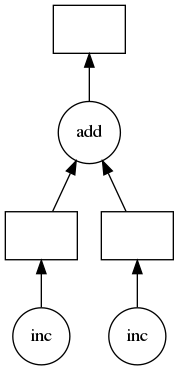

In [21]:
# Look at the task graph for `z`
z.visualize()

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [22]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [23]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 8.73 ms, sys: 2.5 ms, total: 11.2 ms
Wall time: 8.01 s


In [24]:
total

44

In [25]:
%%time
# Your parallel code here...

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.compute()

CPU times: user 15 ms, sys: 1.12 ms, total: 16.1 ms
Wall time: 2.01 s


44

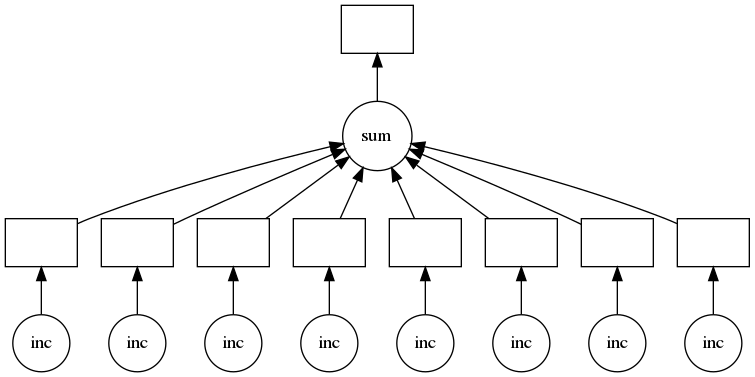

In [26]:
total.visualize()

In [ ]:
%load solutions/01-delayed-loop.py

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [27]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [28]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 12.4 ms, sys: 4.25 ms, total: 16.7 ms
Wall time: 10 s


In [29]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print(total.compute())

90
CPU times: user 16.8 ms, sys: 0 ns, total: 16.8 ms
Wall time: 3.01 s


In [ ]:
%load solutions/01-delayed-control-flow.py

In [ ]:
%time total.compute()

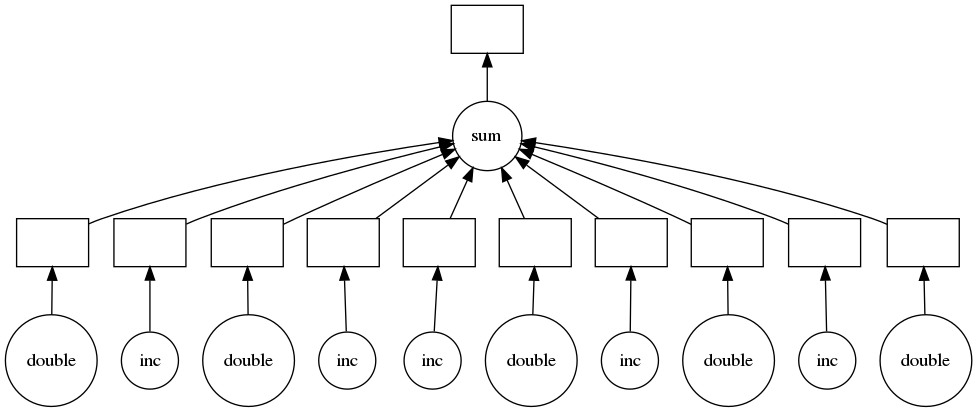

In [30]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

### Prep data

First, run this code to prep some data.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [31]:
#%run prep_data.py

Setting up data directory
-------------------------
- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Finished! **
Create random data for array exercise
Extracting to data/weather-small
Finished!


### Inspect data

In [ ]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

### Read one file with `pandas.read_csv` and compute mean departure delay

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

In [ ]:
# What is the schema?
df.dtypes

In [ ]:
# What originating airports are in the data?
df.Origin.unique()

In [ ]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [ ]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [ ]:
from dask import compute

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

In [ ]:
%load solutions/01-delayed-groupby.py

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?